# Wrinkle segmentation (U-Net)

+ https://universe.roboflow.com/teknofest23/wrinkle-segmentation-5iatyhttps://universe.roboflow.com/teknofest23/wrinkle-segmentation-5iaty     

> 266 epoch      
> Dice score : 0.459

In [2]:
# Library improt
import os
import copy
import glob
import cv2
import random
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from PIL import Image as PILImage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.utils as vutils
from torchvision import transforms, datasets

# Dataset improt
from Codes.dataset import Dataset, Binary_Dataset
from Codes.data_loader import Data_loader, Binary_Data_loader

# Model import
from Models.Unet.unet_models import UNet, unet
from Models.Unet.unet_parts import *
from Models.Deeplabv3 import deeplabv3_resnet101

# Metrics import
from Codes.metrics import DiceCELoss ,dice_score ,iou ,dice_pytorch_eval, iou_pytorch_eval, DiceBCELoss
from Codes.metrics import DiceLossMulticlass
from Codes.metrics import mIOU

from Codes.ploting import plot_model_prediction, plot_mode_prediction

# cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
      torch.cuda.manual_seed_all(42)

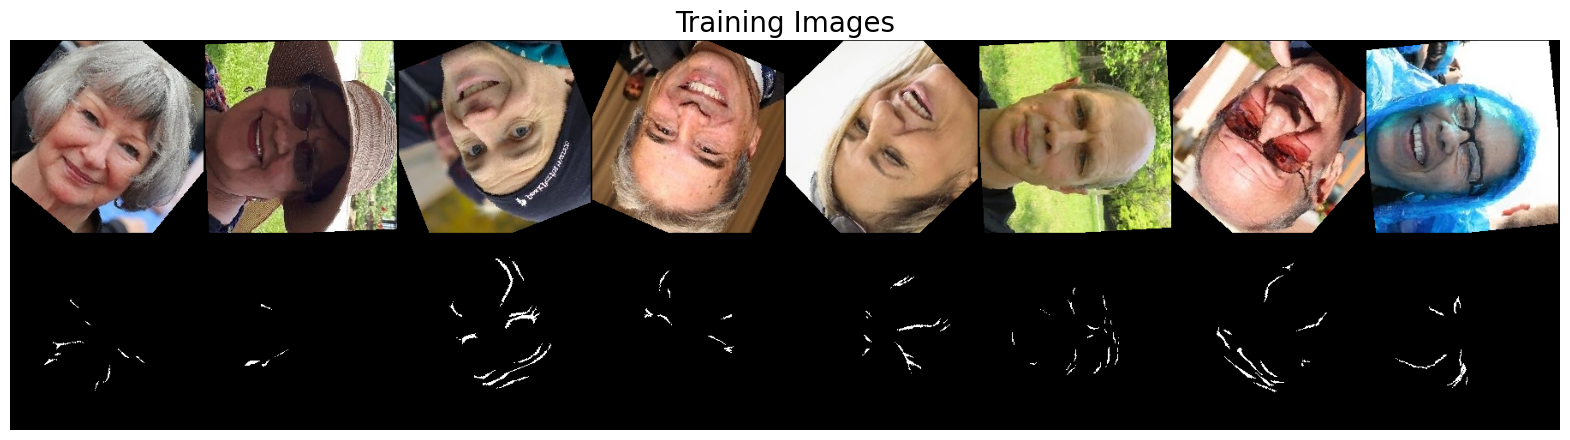

In [ ]:
train_loader, valid_loader, test_loader = Binary_Data_loader('/home/sh/lab/eonc/data/wrinkle/')

one_batch = next(iter(train_loader))
plt.figure(figsize=(20,12))
plt.axis('off')
plt.title('Training Images', fontsize=20)

image = np.transpose(vutils.make_grid(one_batch[0][:8], padding=2, normalize=True).cpu(),(1,2,0))
label = np.transpose(vutils.make_grid(one_batch[1][:8], padding=2, normalize=True).cpu(),(1,2,0))
data = np.concatenate([image, label], axis=0)
plt.imshow(data)
plt.show()

# Set up

In [3]:
epoches = 400
model = UNet(n_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)
criterion = DiceBCELoss()

# Train Loop

In [4]:
train_loss_list, train_dice_list, train_iou_list = [], [], []
valid_loss_list, valid_dice_list, valid_iou_list = [], [], []
state={}
model_name = 'Unet'
n_classes = 1

for epoch in range(1, epoches + 1) :
    train_loss, train_dice, train_iou, train_step = 0, 0, 0, 0
    
    # Train
    model.train()
    for images, mask in train_loader:
        images = images.to(device)
        mask = mask.to(device)
        # true_masks = mask
        # if n_classes < 2 :
        #     true_masks = mask
        # else:   # 1-tensor로 반전시킨 텐서 만들고 겹치쳐서 input과 target의 차원 맞춤
        #     true_masks = torch.stack([1-mask,mask], dim=1).squeeze(2)
            
            
        pred = model(images)  # images.shape : [8, 3, 224, 224]
                              # pred.shape : [8, 1, 224, 224] 
            
        
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if n_classes==1:
            train_iou += iou_pytorch_eval(pred, mask).item()
            train_dice += dice_pytorch_eval(pred, mask).item()

        else:
            train_iou += iou(pred, mask).item()
            train_dice += dice_score(pred, mask).item()
        train_step += 1

    # Validate
    val_loss, val_dice, val_iou, val_step = 0, 0, 0, 0
    
    model.eval()
    with torch.no_grad():
        
        for image, mask in valid_loader:
            image = image.to(device)
            mask = mask.to(device)
            # mask_true = mask

            # if n_classes < 2 :
            #     mask_true = mask
            # else:   # 1-tensor로 반전시킨 텐서 만들고 겹치쳐서 input과 target의 차원 맞춤
            #     mask_true = torch.stack([1-mask,mask], dim=1).squeeze(2)        

            mask_pred = model(image)

            loss = criterion(mask_pred, mask)
            val_loss += loss.item()
            if n_classes==1:
                val_iou += iou_pytorch_eval(mask_pred, mask).item()
                val_dice += dice_pytorch_eval(mask_pred, mask).item()

            else:
                val_iou += iou(mask_pred, mask).item()
                val_dice += dice_score(mask_pred, mask).item()
            val_step += 1     
        
# ------------------------------------------------------------------------------------------------        

    train_dice = round(train_dice / train_step, 3)      
    train_iou = round(train_iou / train_step, 3)
    train_loss = round(train_loss / train_step, 3)
    
    val_dice = round(val_dice / val_step, 3)
    val_iou = round(val_iou / val_step, 3)
    val_loss = round(val_loss / val_step, 3)
    
    print(f'Epoch: {epoch}/{epoches}, Train Dice: {train_dice}, Train Iou: {train_iou}, Train Loss: {train_loss}')
    print(f'Epoch: {epoch}/{epoches}, Valid Dice: {val_dice}, Valid Iou: {val_iou}, Valid Loss: {val_loss}\n')
    
    
    # save list
    train_dice_list.append(train_dice)
    train_iou_list.append(train_iou)
    train_loss_list.append(train_loss)

    valid_dice_list.append(val_dice)
    valid_iou_list.append(val_iou)
    valid_loss_list.append(val_loss)
    
    if np.max(valid_dice_list) <= val_dice:
        state['epoch'] = epoch
        state['net'] = copy.deepcopy(model.state_dict())

        state['train_dice'] = train_dice
        state['train_iou'] = train_iou
        state['train_loss'] = train_loss

        state['val_dice'] = val_dice
        state['val_iou'] = val_iou
        state['val_loss'] = val_loss    
        
torch.save(state, '/home/sh/lab/eonc/check_points/{}_{}_{}.pth'.format(model_name, state['epoch'], state['val_dice']))
print('total best epoch : {} / dice_score : {} / Iou : {} / Loss : {}'.format(state['epoch'], state['val_dice'],state['val_iou'],state['val_loss']))
# score_plot(epoch,state,train_dice_list,train_iou_list,train_loss_list,valid_dice_list,valid_iou_list,valid_loss_list)

Epoch: 1/400, Train Dice: 0.02, Train Iou: 0.01, Train Loss: 1.583
Epoch: 1/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.652

Epoch: 2/400, Train Dice: 0.023, Train Iou: 0.012, Train Loss: 1.513
Epoch: 2/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.628

Epoch: 3/400, Train Dice: 0.012, Train Iou: 0.006, Train Loss: 1.448
Epoch: 3/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.568

Epoch: 4/400, Train Dice: 0.003, Train Iou: 0.001, Train Loss: 1.385
Epoch: 4/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.456

Epoch: 5/400, Train Dice: 0.0, Train Iou: 0.0, Train Loss: 1.342
Epoch: 5/400, Valid Dice: 0.001, Valid Iou: 0.001, Valid Loss: 1.46

Epoch: 6/400, Train Dice: 0.0, Train Iou: 0.0, Train Loss: 1.322
Epoch: 6/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.339

Epoch: 7/400, Train Dice: 0.0, Train Iou: 0.0, Train Loss: 1.307
Epoch: 7/400, Valid Dice: 0.0, Valid Iou: 0.0, Valid Loss: 1.319

Epoch: 8/400, Train Dice: 0.0, Train Iou: 0.0, Train Loss: 1.297
E

# Inference

In [ ]:
model = unet(outchannels=1).to(device)
model.load_state_dict(torch.load('check_points/Unet_266_0.459.pth')['net'])

Using cache found in /home/sh/.cache/torch/hub/milesial_Pytorch-UNet_master


<All keys matched successfully>

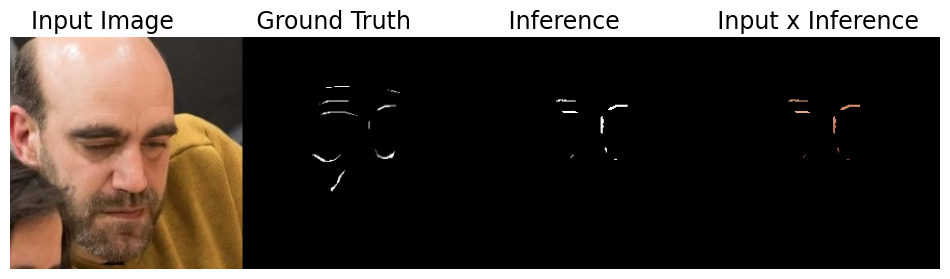

In [70]:
valid_images = sorted(glob.glob('/home/sh/lab/eonc/data/wrinkle_images/*'))
valid_labels = sorted(glob.glob('/home/sh/lab/eonc/data/wrinkle_labels//*'))

size = (224, 224)

i = random.sample(list(np.arange(0, len(valid_images))), 1)
i = i[0]
path_img = valid_images[i]
path_label = valid_labels[i]

# figure 생성
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.axis('off')

# eval 전 이미지 전처리
img = cv2.imread(path_img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# 양성형 이웃 보간 (2x2 픽셀 참조하여 보간함.)
img = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)

# label 이미지 전처리
label = cv2.imread(path_label) * 255
# 양성형 이웃 보간 (2x2 픽셀 참조하여 보간함.)
label = cv2.resize(label, size, interpolation = cv2.INTER_LINEAR)

model.eval()
eval_image = img / 255.0
eval_image = eval_image.astype(np.float32)
eval_image = eval_image.transpose((2,0,1))
eval_image = torch.from_numpy(eval_image).unsqueeze(0) # Batch 채널 추가 -> (1, 3, 256, 256)
eval_image = eval_image.to( device=device, dtype = torch.float32 )


# we do not need to calculate gradients
with torch.no_grad():
    # Prediction
    pred = model(eval_image)  # (1, 1, 224, 224)

# put on cpu
#     pred = pred.cpu()

# pass sigloid 
# pred = torch.sigmoid(pred)

#     # dict형태로 데이터가 들어오는 경우가 있음 ######################################################################

if isinstance(pred, dict):
    pred = torch.sigmoid(pred['out'])

else:
    pred = torch.sigmoid(pred)  

mask = pred.clone()   # (1, 1, 224, 224)

# 0.5를 기준으로 마스크 만들기.
mask[mask >= 0.5 ] = 1
mask[mask < 0.5 ] = 0
with torch.no_grad(): 
#   mask = torch.argmax( mask, dim=1 )  # argmax 하기전에는 (1, 2, 224, 224)
  mask = mask.squeeze() # (2, 224, 224) 오류 남 (224, 224)가 되야함!


mask = mask.to(device = 'cpu', dtype = torch.int64).numpy() # tensor to numpy (반드시 디바이스도 변경)
mask = np.stack( (mask,)*3, axis=-1 ) # (256,256,3)

# 마스킹을 보여주기 위해 흰색처리
real_mask = mask.copy()
real_mask[real_mask == 1] = 255

# segmentationed image
masked_img = img * mask

# 예측 결과 plot
combined = np.concatenate([img, label, real_mask, masked_img], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.title('Input Image           Ground Truth             Inference             Input x Inference', fontsize=17)
plt.show() 

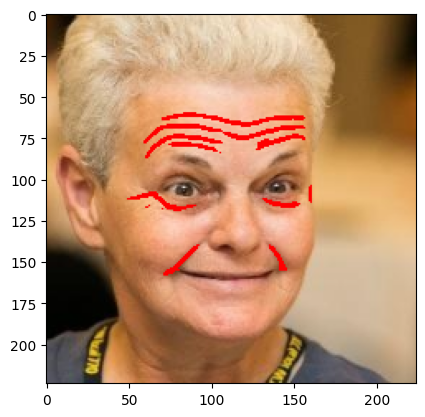

In [104]:
result_img = img.copy()
result_img[mask == 1] = 0
reslut_mask = mask.copy()
reslut_mask_0, reslut_mask_1, reslut_mask_2 = reslut_mask[:,:,0], reslut_mask[:,:,1], reslut_mask[:,:,2]
reslut_mask_0[reslut_mask_0 == 1] = color_dict['red'][0]
reslut_mask_1[reslut_mask_1 == 1] = color_dict['red'][1]
reslut_mask_2[reslut_mask_2 == 1] = color_dict['red'][2]

plt.imshow(result_img + reslut_mask)